In [1]:
from helper_functions import *
from classes import *
from fold_functions import *
from torch.utils.data import DataLoader
from torchvision import transforms
from timeit import default_timer as timer
import datetime
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import os
import zipfile
from pathlib import Path
from tqdm.auto import tqdm
import requests
import seaborn as sns
from sklearn.metrics import confusion_matrix
import shutil


In [2]:
# Define the hyperparameters
BATCH_SIZE = 32 # Batch size for the dataloaders
IN_CHANNELS = 3 # Number of input channels
HIDDEN_UNITS = 16  # Number of hidden units in the fully connected layer
NUM_CLASSES = 4 # Number of classes in the dataset
SIZE = 224 # Size of the images
LEARNING_RATE = 0.001 # Learning rate for the optimizer
EPOCHS = 10 # Number of epochs to train the model
GAMMA = 0.1 # Multiplicative factor of learning rate decay
STEP_SIZE = 5 # Step size for the learning rate scheduler
WEIGHT_DECAY = 0.025 # Weight decay for the optimizer
SEED = 42 # Seed for reproducibility
EVAL_EPOCHS = 10  # Number of epochs to evaluate the model on the test set
RANDOM_ROTATION = 10  # Random rotation for the images
K_FOLDS = 5  # Number of folds for the cross-validation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.RandomRotation(RANDOM_ROTATION),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) if IN_CHANNELS == 3 else transforms.Normalize(mean=[0.5], std=[0.5])
])


train_dataset = CustomDataset('data/Training', transform=transform)
test_dataset = CustomDataset('data/Testing', transform=transform)

# Data loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Classes:  ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


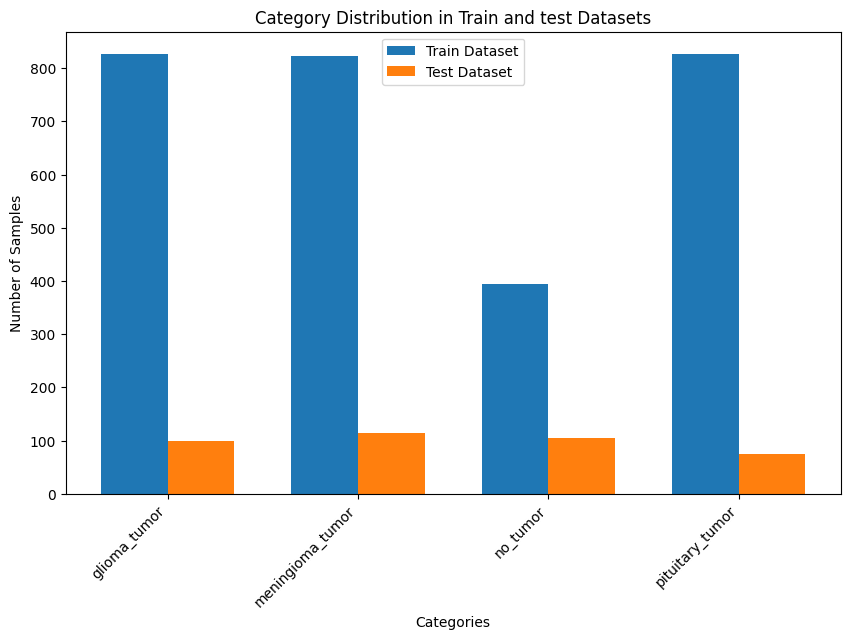

In [4]:
plot_category_distribution(train_dataset, test_dataset)

In [5]:
# Create the combined dataset
combine_dir = combine_and_rename_images('data')

# Walk through the directory and create the dataset
walk_through_dir(combine_dir)

Images combined and renamed successfully.
There are 4 directories and 0 images in 'data\Combined'.
There are 0 directories and 826 images in 'data\Combined\glioma_tumor'.
There are 0 directories and 822 images in 'data\Combined\meningioma_tumor'.
There are 0 directories and 395 images in 'data\Combined\no_tumor'.
There are 0 directories and 827 images in 'data\Combined\pituitary_tumor'.


In [6]:
# Create folded dataset 
out_dir, fold_dirs = create_folds(combine_dir, f'K_Folded_{K_FOLDS}', K_FOLDS)

# Walk through the directory and create the dataset
walk_through_dir(out_dir)

5 folds created successfully.
There are 5 directories and 0 images in 'K_Folded_5'.
There are 4 directories and 0 images in 'K_Folded_5\Fold_1'.
There are 0 directories and 165 images in 'K_Folded_5\Fold_1\glioma_tumor'.
There are 0 directories and 164 images in 'K_Folded_5\Fold_1\meningioma_tumor'.
There are 0 directories and 79 images in 'K_Folded_5\Fold_1\no_tumor'.
There are 0 directories and 165 images in 'K_Folded_5\Fold_1\pituitary_tumor'.
There are 4 directories and 0 images in 'K_Folded_5\Fold_2'.
There are 0 directories and 165 images in 'K_Folded_5\Fold_2\glioma_tumor'.
There are 0 directories and 164 images in 'K_Folded_5\Fold_2\meningioma_tumor'.
There are 0 directories and 79 images in 'K_Folded_5\Fold_2\no_tumor'.
There are 0 directories and 165 images in 'K_Folded_5\Fold_2\pituitary_tumor'.
There are 4 directories and 0 images in 'K_Folded_5\Fold_3'.
There are 0 directories and 165 images in 'K_Folded_5\Fold_3\glioma_tumor'.
There are 0 directories and 164 images in 'K_

In [ ]:
fold_datasets = []

# Create the list of datasets for the folds
for i in range(K_FOLDS):
    fold_dataset = CustomDataset(fold_dirs[i], transform=transform)
    fold_datasets.append(fold_dataset)
    

In [ ]:
for i in range(len(fold_datasets)):
    print(f'Fold {i+1} has {len(fold_datasets[i])} samples')

In [ ]:
# Prepare the data loaders for the folds
train_loader_fold = []
val_loader_fold = []

for i in range(K_FOLDS):
    train_dirs = [fold_dirs[j] for j in range(K_FOLDS) if j != i]
    val_dir = fold_dirs[i]

    train_dataset_fold = CustomFoldDataset(train_dirs, transform=transform)
    val_dataset_fold = CustomDataset(val_dir, transform=transform)

    train_loader_fold.append(DataLoader(train_dataset_fold, batch_size=BATCH_SIZE, shuffle=True))
    val_loader_fold.append(DataLoader(val_dataset_fold, batch_size=BATCH_SIZE, shuffle=False))



In [ ]:
res_per_fold_combination = []
model_array = []

for i in range(K_FOLDS):
    print(f"Fold {i + 1}:")
    train_loader = train_loader_fold[i]
    val_loader = val_loader_fold[i]
    model = MRI_classification_CNN(IN_CHANNELS, HIDDEN_UNITS, NUM_CLASSES, SIZE).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # Define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    # Train the model
    results = fold_train(model, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE, K_FOLDS, scheduler)

    model_array.append(model)
    res_per_fold_combination.append(results)

In [ ]:
# Compare witch model is the best one
for i in range(len(res_per_fold_combination)):  
    print(f"Fold {i + 1}:")
    print(f"Training Accuracy: {res_per_fold_combination[i]['train_acc'][-1]:.4f}")
    print(f"Validation Accuracy: {res_per_fold_combination[i]['test_acc'][-1]:.4f}")
    print(f"Training Loss: {res_per_fold_combination[i]['train_loss'][-1]:.4f}")
    print(f"Validation Loss: {res_per_fold_combination[i]['test_loss'][-1]:.4f}")